# Домашнее задание 2

### Выполнил Штанько Константин, группа 1, вариант 26

#### **Пункт а):**
Для начала нам необходимо получить `таблицу сопряженности наблюдаемых частот безработных` *(дес. тыс. чел.)* по **времени поиска работы** и **возрасту**:

In [37]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
import matplotlib.pyplot as plt
import statsmodels.graphics.mosaicplot as mosaic


df = pd.read_excel('sani2.xlsx', index_col = 0, header = 0)
df.columns.name = 'Возрастные группы'
df.index.name = 'Период времени'
print('Таблица сопряженности наблюдаемых частот числа безработных по времени поиска работы (строки) и возрасту (столбцы):')
df

Таблица сопряженности наблюдаемых частот числа безработных по времени поиска работы (строки) и возрасту (столбцы):


Возрастные группы,15-24,25-34,35-44,45-54,55 и старше
Период времени,,,,,
менее 1 месяца,26,25,14,6,5
от 1 до 6 месяцев,58,44,28,22,12
6 и более месяцев,27,53,40,36,23


Посмотрим на таблицу сопряженности `теоретических частот`:

In [38]:
chi2, p, dof, expectancy = chi2_contingency(df)
expected = pd.DataFrame(expectancy, index=df.index, columns=df.columns)
print('Таблица сопряженности теоретических частот:')
expected

Таблица сопряженности теоретических частот:


Возрастные группы,15-24,25-34,35-44,45-54,55 и старше
Период времени,,,,,
менее 1 месяца,20.133652,22.128878,14.873508,11.608592,7.255370
от 1 до 6 месяцев,43.446301,47.751790,32.095465,25.050119,15.656325
6 и более месяцев,47.420048,52.119332,35.031026,27.341289,17.088305


#### **Пункт б):**
Проверим гипотезы независимости на основе `критерия согласия Пирсона` при уровне значимости **0.01**:

In [39]:
print('Полученное значение Хи-квадрат наблюдаемого:')
print(f'{chi2:.2f}')

Полученное значение хи-квадрат наблюдаемого:
26.76


In [40]:
print('Полученное значение p-value:')
print(f'{p:.4f}')
if p < 0.01:
    print('Следовательно, гипотеза о независимости признаков отвергается с вероятностью\nошибки 0.01, следовательно, возраст и период времени безработицы связаны')
else:
    print('Гипотеза о независимости признаков не отвергается на уровне\nзначимости 0.01, следовательно, возраст и период времени безработицы не связаны')

Полученное значение p-value:
0.0008
Следовательно, гипотеза о независимости признаков отвергается с вероятностью
ошибки 0.01, следовательно, возраст и период времени безработицы связаны


Таким образом, гипотеза о независимости признаков отвергается с вероятностью ошибки **0.01**, что свидетельствует о `наличии зависимости` между возрастом и временем поиска работы.

#### **Пункт в):**
Получим точечную и интервальную оценку `коэффициента Крамера` на основе **нецентрального Хи-квадрат распределения**:

In [41]:
from rpy2.robjects import IntVector

vcd = importr('vcd')
DescTools = importr('DescTools')

r_data = IntVector(df.values.flatten().tolist())

r_table = ro.r.matrix(
    r_data,
    nrow=df.shape[0],
    ncol=df.shape[1],
    byrow=True,
    dimnames=ro.r.list(df.index.tolist(), df.columns.tolist()
))
cramer_coeff = vcd.assocstats(r_table).rx2('cramer')
print('Коэффициент Крамера составляет:')
round(float(cramer_coeff[0]), 4)

Коэффициент Крамера составляет:


0.1787

Следовательно, можно заметить, что `связь между признаками (возрастом и временем) слабая`. Данный коэффициент показывает только силу связи, а не ее направление.

Теперь посчитаем `интервальную оценку коэффициента Крамера на основе нецентрального Хи-квадрат с коррекцией смещения`:

In [96]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()


MBESS = importr('MBESS')

K_kramer = DescTools.CramerV(r_table, conf_level = 0.92, method = "ncchisqadj")
lower_k = K_kramer[1]
upper_k = K_kramer[2]
print(f'92%-ый доверительный интервал для коэффициента Крамера: ({lower_k:.4f}, {upper_k:.4f})')

92%-ый доверительный интервал для коэффициента Крамера: (0.1296, 0.2388)


Получается, так как ноль не входит в доверительный интервал, то можно сделать вывод, что `коэффициент Крамера значимо отличается от нуля`.

Посчитаем точечные и интервальные оценки `коэффициента лямбда(b)` и `тау(а)` на уровне значимости 97%:

In [81]:
DescTools = importr('DescTools')
lambda_b = DescTools.Lambda(r_table, direction="column", conf_level=0.97)
print(f"Лямбда(b): {lambda_b[0]:.5f}")
print(f'97%-ый доверительный интервал для коэффициента лямбда(b): ({lambda_b[1]:.6f}, {lambda_b[2]:.6f})')

Лямбда(b): 0.05051
97%-ый доверительный интервал для коэффициента лямбда(b): (0.000000, 0.138572)


Следовательно, `вероятность предсказания возраста может быть снижена на 0.05` при известном временном промежутке по сравнению с ситуацией, когда эта информация отсутствует. По доверительному интервалу можно понять, что коэффициент незначимо отличается от нуля.

In [45]:
tau_a = DescTools.GoodmanKruskalTau(r_table, direction = "row", conf_level = 0.97)
print(f"Тау(а): {tau_a[0]:.3f}")
print(f'97%-ый доверительный интервал для коэффициента тау(а): ({tau_a[1]:.3f}, {tau_a[2]:.3f})')

Тау(а): 0.037
97%-ый доверительный интервал для коэффициента тау(а): (0.007, 0.067)


Таким образом, `вероятность предсказания времени безработицы может быть снижена на 0.037` при известной возрастной группе по сравнению с ситуацией, когда эта информация отсутствует в случае пропорционального прогнозирования. В доверительном интервале этого коэффициента нет нуля, поэтому данный коэффициент значимо отличается от нуля.

#### **Пункт г):**
Получим `мозаичный график` таблицы сопряженности, в котором в качестве основного признака рассматривается **возрастная группа**:

/opt/homebrew/lib/python3.13/site-packages/statsmodels/graphics/mosaicplot.py:651: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  Rect = Rectangle((x, y), w, h, label=text, **props)


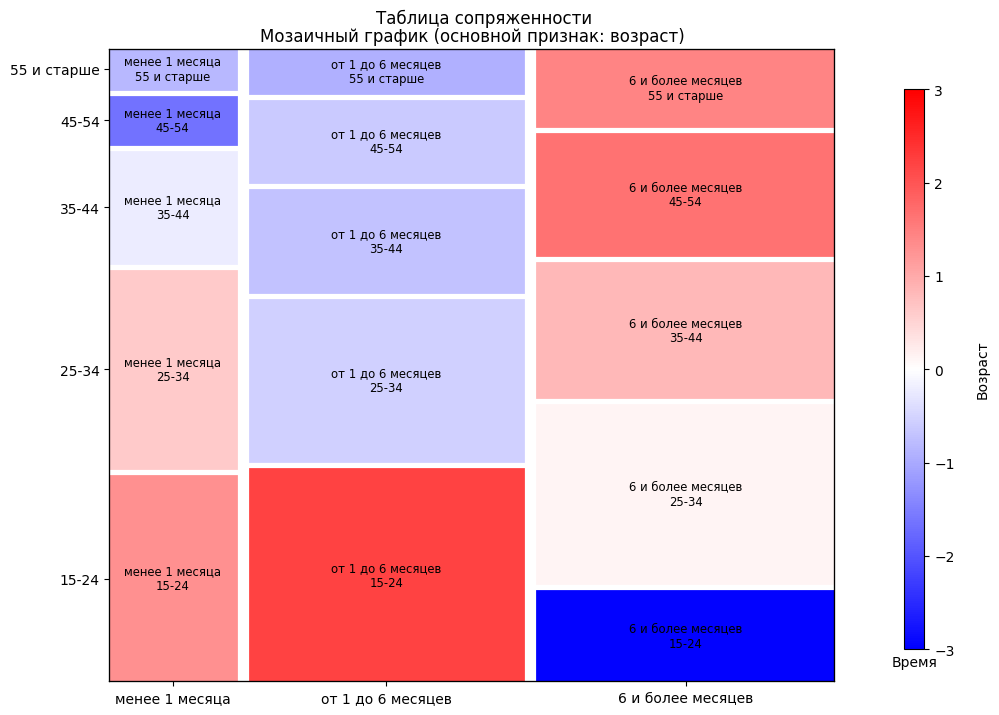

In [75]:
plt.figure(figsize=(10, 8))

ax = plt.gca()

mosaic.mosaic(
    df.stack(),
    title='Мозаичный график (основной признак: возраст)',
    properties=lambda key: {'color': get_color(key), 'edgecolor': 'black', 'linewidth': 2, 'linestyle': '-'},
    gap=0.02,
    axes_label=True,
    ax=ax
)

fig = plt.gcf()
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])


sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-3, vmax=3))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Отклонение', labelpad=15)

plt.subplots_adjust(
    right=0.85,
    top=0.9      
)
plt.xlabel('Время')
plt.ylabel('Возраст')
plt.suptitle('Таблица сопряженности', y=0.95)
plt.xticks(rotation=45, ha='right')

plt.show()